In [1]:
# install wandb in colab (if required)
!pip install wandb

In [2]:
# login (if required)
import wandb

### REGIME !!!
regime_str = "repr_regime"

### WANDB PROJECT NAME !!!
wandb_project_name = f"gnn_1d_logistic_pinnsformer_{regime_str}"
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: padieul to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [3]:
import torch
import os
import copy
import sys
from pathlib import Path
from dataclasses import dataclass, field
from typing import Optional
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, TensorDataset
import random
from torch.optim import LBFGS, Adam
from pathlib import Path
from tqdm import tqdm

# make sure that util is correctly accessed from parent directory
ppp_dir = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
if ppp_dir not in sys.path:
    sys.path.insert(0, ppp_dir)


In [4]:
def get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])

class WaveAct(nn.Module):
    def __init__(self):
        super(WaveAct, self).__init__()
        self.w1 = nn.Parameter(torch.ones(1), requires_grad=True)
        self.w2 = nn.Parameter(torch.ones(1), requires_grad=True)

    def forward(self, x):
        return self.w1 * torch.sin(x)+ self.w2 * torch.cos(x)

class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=256):
        super(FeedForward, self).__init__()
        self.linear = nn.Sequential(*[
            nn.Linear(d_model, d_ff),
            WaveAct(),
            nn.Linear(d_ff, d_ff),
            WaveAct(),
            nn.Linear(d_ff, d_model)
        ])

    def forward(self, x):
        return self.linear(x)


class EncoderLayer(nn.Module):
    def __init__(self, d_model, heads):
        super(EncoderLayer, self).__init__()

        self.attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=heads, batch_first=True)
        self.ff = FeedForward(d_model)
        self.act1 = WaveAct()
        self.act2 = WaveAct()

    def forward(self, x):
        x2 = self.act1(x)
        # pdb.set_trace()
        x = x + self.attn(x2,x2,x2)[0]
        x2 = self.act2(x)
        x = x + self.ff(x2)
        return x


class DecoderLayer(nn.Module):
    def __init__(self, d_model, heads):
        super(DecoderLayer, self).__init__()

        self.attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=heads, batch_first=True)
        self.ff = FeedForward(d_model)
        self.act1 = WaveAct()
        self.act2 = WaveAct()

    def forward(self, x, e_outputs):
        x2 = self.act1(x)
        x = x + self.attn(x2, e_outputs, e_outputs)[0]
        x2 = self.act2(x)
        x = x + self.ff(x2)
        return x


class Encoder(nn.Module):
    def __init__(self, d_model, N, heads):
        super(Encoder, self).__init__()
        self.N = N
        self.layers = get_clones(EncoderLayer(d_model, heads), N)
        self.act = WaveAct()

    def forward(self, x):
        for i in range(self.N):
            x = self.layers[i](x)
        return self.act(x)


class Decoder(nn.Module):
    def __init__(self, d_model, N, heads):
        super(Decoder, self).__init__()
        self.N = N
        self.layers = get_clones(DecoderLayer(d_model, heads), N)
        self.act = WaveAct()

    def forward(self, x, e_outputs):
        for i in range(self.N):
            x = self.layers[i](x, e_outputs)
        return self.act(x)


class PINNsformer(nn.Module):
    def __init__(self, d_out, d_model, d_hidden, N, heads):
        """
        Adapted PINNsformer that takes three inputs: x, t, and rho.
        Args:
            d_out (int): Output dimension.
            d_model (int): Dimension of the model embeddings.
            d_hidden (int): Hidden layer dimension in the output MLP.
            N (int): Number of encoder/decoder layers.
            heads (int): Number of attention heads.
        """
        super(PINNsformer, self).__init__()
        # Change input dimension from 2 to 3 to accommodate x, t, and rho
        self.linear_emb = nn.Linear(3, d_model)

        self.encoder = Encoder(d_model, N, heads)
        self.decoder = Decoder(d_model, N, heads)
        self.linear_out = nn.Sequential(
            nn.Linear(d_model, d_hidden),
            WaveAct(),
            nn.Linear(d_hidden, d_hidden),
            WaveAct(),
            nn.Linear(d_hidden, d_out)
        )

    def forward(self, x, t, rho):
        # Concatenate x, t, and rho along the last dimension
        src = torch.cat((x, t, rho), dim=-1)
        src = self.linear_emb(src)

        e_outputs = self.encoder(src)
        d_output = self.decoder(src, e_outputs)
        output = self.linear_out(d_output)
        return output

In [5]:
class ODEData(Dataset):
    def __init__(self, t_range, rho_values, t_points, constant_x, device='cuda:0', use_time_sequencing=False):
        """
        Initialize the dataset for a logistic growth ODE with a constant spatial coordinate.

        Args:
            t_range (list): Time domain [t_min, t_max].
            rho_values (list): List of reaction coefficients (? values).
            t_points (int): Number of time points.
            constant_x (float): The constant spatial coordinate (e.g., a representative location).
            device (str): Device to store the tensors ('cpu' or 'cuda:0').
        """
        self.device = device
        self.t_range = t_range
        self.rho_values = rho_values
        self.t_points = t_points
        self.constant_x = constant_x
        self.use_time_sequencing = use_time_sequencing

        # Prepare data for each rho value.
        self.data = {}
        for rho in rho_values:
            # Generate residual points (time samples with constant x)

            res, ic = self._generate_data()
            if self.use_time_sequencing == True:
                res = self._make_time_sequence(res)
                ic = self._make_time_sequence(ic)

            res_tensor = torch.tensor(res, dtype=torch.float32, requires_grad=True).to(self.device)
            ic_tensor = torch.tensor(ic, dtype=torch.float32, requires_grad=True).to(self.device)

            # Precompute analytical solution at the initial condition (t = t_range[0])
            u_ic = self.analytical_solution(
                torch.tensor([[constant_x]], dtype=torch.float32, requires_grad=True).to(self.device),
                torch.tensor([[t_range[0]]], dtype=torch.float32, requires_grad=True).to(self.device),
                rho
            )

            self.data[rho] = {
                'res': res_tensor,   # (x, t) pairs over the time domain (x is constant)
                'ic': ic_tensor,     # Initial condition point (t = t_range[0])
                'u_ic': u_ic         # Analytical solution at t = t_range[0]
            }

    def _generate_data(self):
        """
        Generate residual points (for the interior of the time domain) and the initial condition.

        Returns:
            res (np.ndarray): Array of shape (t_points, 2) where each row is [constant_x, t].
            ic (np.ndarray): Array of shape (1, 2) corresponding to the initial condition at t = t_range[0].
        """
        # Create time samples
        t = np.linspace(self.t_range[0], self.t_range[1], self.t_points)
        # For each t, x is always the constant value provided.
        x = self.constant_x * np.ones_like(t)
        # Stack x and t to create our (x,t) pairs.
        res = np.stack([x, t], axis=-1)  # Shape: (t_points, 2)
        # The initial condition is simply the first row.
        ic = res[0:1, :]
        return res, ic

    def analytical_solution(self, x, t, rho):
        """
        Compute the analytical solution for the logistic growth ODE.
        Here we use the same functional form as before:

        u(t) = h(x) * exp(? t) / (h(x) * exp(? t) + 1 - h(x)),  with
        h(x) = exp( - (x - ?)? / [2*(?/4)?] ).

        Note: Since x is constant, h(x) is also constant.

        Args:
            x (torch.Tensor): The spatial input (constant value).
            t (torch.Tensor): Time input.
            rho (float): Reaction coefficient.

        Returns:
            torch.Tensor: The analytical solution.
        """
        pi = torch.tensor(np.pi, dtype=torch.float32, device=self.device)
        h = torch.exp(- (x - pi)**2 / (2 * (pi / 4)**2))
        return h * torch.exp(rho * t) / (h * torch.exp(rho * t) + 1 - h)

    def get_test_points(self, rho):
        """
        For this simple ODE experiment, the test points are the same as the interior points.

        Returns:
            x, t, rho tensor.
        """
        return self.get_interior_points(rho)

    def _make_time_sequence(self, src, num_step=5, step=1e-4):
        dim = num_step
        src = np.repeat(np.expand_dims(src, axis=1), dim, axis=1)  # (N, L, 2)
        for i in range(num_step):
            src[:,i,-1] += step*i
        return src

    def get_interior_points(self, rho):
        """
        Retrieve the interior (residual) points for a given rho.
        """
        res = self.data[rho]['res']
        if self.use_time_sequencing:
            x = res[:, :, 0:1]  # Shape: (N, num_step, 1)
            t = res[:, :, 1:2]  # Shape: (N, num_step, 1)
        else:
            x = res[:, 0:1]
            t = res[:, 1:2]

        # Create appropriate rho tensor
        if self.use_time_sequencing:
            rho_tensor = torch.full_like(x, rho)
        else:
            rho_tensor = torch.full_like(x, rho)

        return x, t, rho_tensor

    def get_initial_condition(self, rho):
        """
        Retrieve the initial condition point and its analytical solution.
        """
        ic = self.data[rho]['ic']
        if self.use_time_sequencing:
            x_ic = ic[:, :, 0:1]  # Shape: (1, num_step, 1)
            t_ic = ic[:, :, 1:2]  # Shape: (1, num_step, 1)
        else:
            x_ic = ic[:, 0:1]
            t_ic = ic[:, 1:2]

        # Create appropriate rho tensor
        if self.use_time_sequencing:
            rho_tensor = torch.full_like(x_ic, rho)
        else:
            rho_tensor = torch.full_like(x_ic, rho)

        u_ic = self.data[rho]['u_ic']

        return x_ic, t_ic, rho_tensor, u_ic

    def get_interior_input_without_points(self):
        """
        Generate interior input points dynamically without precomputed values.
        """
        res, _ = self._generate_data()

        if self.use_time_sequencing:
            res = self._make_time_sequence(res)
            res_tensor = torch.tensor(res, dtype=torch.float32, requires_grad=True).to(self.device)
            x = res_tensor[:, :, 0:1]  # Shape: (N, num_step, 1)
            t = res_tensor[:, :, 1:2]  # Shape: (N, num_step, 1)
        else:
            res_tensor = torch.tensor(res, dtype=torch.float32, requires_grad=True).to(self.device)
            x = res_tensor[:, 0:1]
            t = res_tensor[:, 1:2]

        return x, t, None



In [6]:
@dataclass
class HyperparamConfig:
    # General parameters
    total_i: int = None
    dataset: str = None
    model_name: str = None
    in_dim: int = None
    hidden_dim: int = None
    out_dim: int = None
    num_layer: int = None
    init_weights: str = None
    bias_fill: float = None

    # Model-specific parameters (only relevant if model_name is "pinn_ff")
    init_activ_func: Optional[str] = None  # Only relevant for "pinn_ff"       # sin , tanh, gelu
    subseq_activ_func: Optional[str] = None  # Only relevant for "pinn_ff"     # tanh, gelu

    # Only relevant if model_name is "pinnsformer"
    emb_dim: Optional[int] = field(default=None)
    num_heads: Optional[int] = field(default=None)

    # Optimizer parameters
    optimizer: str = "adam"  # Options: "adam", "lbfgs"
    learning_rate: Optional[float] = field(default=None)  # Only relevant for Adam
    batch_size: Optional[int] = field(default=None)  # Only relevant for Adam

    # LBFGS-specific parameters
    max_iter: Optional[int] = field(default=None)  # Only relevant for LBFGS
    line_search_fn: Optional[str] = field(default=None)  # Only relevant for LBFGS

    # Normalization parameters
    normalize_res: bool = False
    normalize_ic: bool = False
    alpha: Optional[float] = None  # Only relevant if normalize_res or normalize_ic is True
    epsilon: Optional[float] = None  # Only relevant if normalize_res or normalize_ic is True

    # Adaptive loss weighting
    adaptive_loss_weighting: bool = False
    adaptive_loss_coeff: Optional[float] = field(default=None)

    def validate(self):
        """
        Validate the configuration to ensure all conditional parameters are set correctly.
        """
        # Validate optimizer-specific parameters
        if self.optimizer == "adam":
            if self.learning_rate is None:
                raise ValueError("`learning_rate` must be specified when optimizer is 'adam'.")
            if self.batch_size is None:
                raise ValueError("`batch_size` must be specified when optimizer is 'adam'.")
        elif self.optimizer == "lbfgs":
            if self.max_iter is None:
                raise ValueError("`max_iter` must be specified when optimizer is 'lbfgs'.")
            if self.line_search_fn is None:
                raise ValueError("`line_search_fn` must be specified when optimizer is 'lbfgs'.")

        # Validate model-specific parameters
        if self.model_name == "pinn_ff":
            if self.init_activ_func is None:
                raise ValueError("`init_activ_func` must be specified when model_name is 'pinn_ff'.")
            if self.subseq_activ_func is None:
                raise ValueError("`subseq_activ_func` must be specified when model_name is 'pinn_ff'.")

        if self.model_name == "pinnsformer":
            if self.emb_dim is None:
                raise ValueError("`emb_dim` must be specified when model_name is 'pinnsformer'.")
            if self.num_heads is None:
                raise ValueError("`num_heads` must be specified when model_name is 'pinnsformer'.")


        # Validate normalization-specific parameters
        if self.normalize_res or self.normalize_ic:
            if self.alpha is None:
                raise ValueError("`alpha` must be specified when normalize_res or normalize_ic is True.")
            if self.epsilon is None:
                raise ValueError("`epsilon` must be specified when normalize_res or normalize_ic is True.")

    def to_dict(self):
        """
        Convert the dataclass to a dictionary for use with wandb or other logging tools.
        """
        return {k: v for k, v in self.__dict__.items() if v is not None}

In [7]:
base_dir = Path(".") / f"{regime_str}" # Base directory for results
images_dir = base_dir / "images"  # Subdirectory for images
weights_dir = base_dir / "weights"  # Subdirectory for stored model

# Create the directories if they don't exist
images_dir.mkdir(parents=True, exist_ok=True)
weights_dir.mkdir(parents=True, exist_ok=True)

In [8]:
cuda_available = torch.cuda.is_available()
print(f"CUDA available: {cuda_available}")

# If CUDA is available, print the CUDA version
if cuda_available:
    print(f"CUDA version: {torch.version.cuda}")
    print(f"Number of CUDA devices: {torch.cuda.device_count()}")
    print(f"Current CUDA device: {torch.cuda.current_device()}")
    print(f"CUDA device name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
    device = 'cuda:0'

seed = 0
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

"""
import torch.backends.cudnn as cudnn
torch.use_deterministic_algorithms(True)
cudnn.deterministic = True
cudnn.benchmark = False
"""



CUDA available: True
CUDA version: 12.4
Number of CUDA devices: 1
Current CUDA device: 0
CUDA device name: Tesla T4


'\nimport torch.backends.cudnn as cudnn\ntorch.use_deterministic_algorithms(True)\ncudnn.deterministic = True\ncudnn.benchmark = False\n'

### Configure initial dataset and hyperparameters

In [9]:
config = HyperparamConfig(
    total_i=10,
    dataset="1d-logistic-ode",
    model_name="pinnsformer",  # Model name
    in_dim=3,
    hidden_dim=256,
    out_dim=1,
    emb_dim=32,
    num_layer=1,
    num_heads=2,
    init_weights="xavier uniform",
    bias_fill=0.01,
    optimizer="adam",
    learning_rate=0.001,
    batch_size=128
)

# Validate the configuration
config.validate()

print("Configuration:")
print(config.to_dict())

Configuration:
{'total_i': 10, 'dataset': '1d-logistic-ode', 'model_name': 'pinnsformer', 'in_dim': 3, 'hidden_dim': 256, 'out_dim': 1, 'num_layer': 1, 'init_weights': 'xavier uniform', 'bias_fill': 0.01, 'emb_dim': 32, 'num_heads': 2, 'optimizer': 'adam', 'learning_rate': 0.001, 'batch_size': 128, 'normalize_res': False, 'normalize_ic': False, 'adaptive_loss_weighting': False}


### 1. Hyperparameter Tuning: Small $\rho$ parameter variance datasets, adam optimizer with mini batching

In [10]:
def generate_rho_values(start, end, num=10):
    return np.linspace(start, end, num).tolist()

In [11]:
def compute_relative_errors(model, dataset, rho, device):
    # Get test points
    x, t, rho_tensor = dataset.get_test_points(rho)

    # Compute predictions
    with torch.no_grad():
        pred = model(x, t, rho_tensor).detach().cpu().numpy()

    # Compute analytical solution
    with torch.no_grad():
        u_analytical = dataset.analytical_solution(x, t, rho).detach().cpu().numpy()

    # Handle time sequencing case (shapes will be different)
    if dataset.use_time_sequencing:
        # Option 1: Reshape predictions to match analytical solution
        if pred.shape != u_analytical.shape:
            if len(pred.shape) == 3:  # If pred has shape (N, num_step, 1)
                pred = pred.reshape(-1, 1)  # Flatten to (N*num_step, 1)
            if len(u_analytical.shape) == 3:  # If u_analytical has shape (N, num_step, 1)
                u_analytical = u_analytical.reshape(-1, 1)  # Flatten to (N*num_step, 1)

    # Compute relative errors
    rl1 = np.sum(np.abs(u_analytical - pred)) / np.sum(np.abs(u_analytical))
    rl2 = np.sqrt(np.sum((u_analytical - pred) ** 2) / np.sum(u_analytical ** 2))

    return rl1, rl2

In [12]:
# === Helper Functions ===
def compute_grad_norm(loss, model):
    """Compute and normalize gradient of loss w.r.t. model parameters."""
    grads = torch.autograd.grad(loss, model.parameters(), retain_graph=True, create_graph=True)
    flat_grad = torch.cat([g.view(-1) for g in grads if g is not None])
    return flat_grad / (flat_grad.norm() + 1e-8)

def update_momentum(grads, momentum_dict, alpha):
    """Exponential moving average update for gradient momentum."""
    for key in grads:
        if key not in momentum_dict:
            momentum_dict[key] = grads[key].detach().clone()
        else:
            momentum_dict[key] = alpha * momentum_dict[key] + (1 - alpha) * grads[key].detach()
    return momentum_dict

def compute_loss_weights(momentum_dict):
    """Compute inverse-norm weights from gradient momenta."""
    weights = {k: 1.0 / (v.norm() + 1e-8) for k, v in momentum_dict.items()}
    total = sum(weights.values())
    return {k: weights[k] / total for k in weights}

In [13]:
# === Helper Function for One Training Run ===
def run_training(config_dict, model, optim, dataset, rho_values, device):
    """
    Perform one training run based on the provided configuration.

    Args:
        config_dict (dict): Configuration dictionary containing hyperparameters.
        model (torch.nn.Module): The model to train.
        dataset: Dataset object providing interior and initial condition points.
        rho_values (list): List of rho values for training.
        device (torch.device): Device to run the training on (e.g., 'cuda' or 'cpu').
    """
    wandb.init(
        project=wandb_project_name,
        config=config_dict,
        settings=wandb.Settings(silent=True)
    )

    momentum_dict = {}  # Reset for each run
    loss_track = {}
    model.train() # set to training mode

    for i in tqdm(range(config_dict["total_i"])):
        total_loss_res = 0.0
        total_loss_ic = 0.0
        num_batches = 0

        for rho in rho_values:
            x_res, t_res, rho_res = dataset.get_interior_points(rho)
            interior_dataset = TensorDataset(x_res, t_res, rho_res)
            interior_loader = DataLoader(interior_dataset, batch_size=config_dict["batch_size"], shuffle=True)

            x_ic, t_ic, rho_ic, u_ic = dataset.get_initial_condition(rho)

            for bx, bt, brho in interior_loader:
                bx.requires_grad_()
                bt.requires_grad_()

                pred_res = model(bx.to(device), bt.to(device), brho.to(device))
                u_t = torch.autograd.grad(pred_res, bt.to(device), grad_outputs=torch.ones_like(pred_res),
                                          retain_graph=True, create_graph=True)[0]

                if config_dict["normalize_res"]:
                    normalized_res_error = (u_t - brho * pred_res * (1 - pred_res)) / (
                        config_dict["alpha"] * torch.sqrt(brho) + config_dict["epsilon"])
                    loss_res = torch.mean(normalized_res_error ** 2)
                else:
                    loss_res = torch.mean((u_t - brho * pred_res * (1 - pred_res)) ** 2)

                pred_ic = model(x_ic.to(device), t_ic.to(device), rho_ic.to(device))

                if config_dict["normalize_ic"]:
                    normalized_ic_error = (pred_ic - u_ic.to(device)) / (
                        config_dict["alpha"] * torch.sqrt(brho) + config_dict["epsilon"])
                    loss_ic = torch.mean(normalized_ic_error ** 2)
                else:
                    loss_ic = torch.mean((pred_ic - u_ic.to(device)) ** 2)

                if config_dict["adaptive_loss_weighting"]:
                    grad_res = compute_grad_norm(loss_res, model)
                    grad_ic = compute_grad_norm(loss_ic, model)

                    grads = {'res': grad_res, 'ic': grad_ic}
                    momentum_dict = update_momentum(grads, momentum_dict, config_dict["adaptive_loss_coeff"])
                    gamma = compute_loss_weights(momentum_dict)

                    loss = gamma['res'] * loss_res + gamma['ic'] * loss_ic
                else:
                    loss = loss_res + loss_ic

                optim.zero_grad()
                loss.backward(retain_graph=True)
                optim.step()

                total_loss_res += loss_res.item()
                total_loss_ic += loss_ic.item()
                num_batches += 1

        avg_loss_res = total_loss_res / num_batches
        avg_loss_ic = total_loss_ic / num_batches
        avg_total_loss = avg_loss_res + avg_loss_ic

        wandb_dict = {
            "iteration": i,
            "avg_loss_res": avg_loss_res,
            "avg_loss_ic": avg_loss_ic,
            "avg_total_loss": avg_total_loss
        }

        total_l1 = 0.0
        total_l2 = 0.0
        for rho in rho_values:
            rl1, rl2 = compute_relative_errors(model, dataset, rho, device)
            wandb_dict[f"{rho}_rl1"] = rl1
            wandb_dict[f"{rho}_rl2"] = rl2
            total_l1 += rl1
            total_l2 += rl2

        average_l1 = total_l1 / len(rho_values)
        average_l2 = total_l2 / len(rho_values)

        wandb.log(wandb_dict)
        loss_track[i] = wandb_dict

    wandb.finish()
    return loss_track, average_l1, average_l2


In [14]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(config.bias_fill)

In [15]:
def plot_predictions_and_errors(rho_values, predictions, analytical_solutions, errors, num_cols=4, save_path=None):
    """
    Plot predictions and errors for multiple rho values in a grid layout.

    Args:
        rho_values (list): List of rho values.
        predictions (dict): Dictionary of predictions for each rho value.
        analytical_solutions (dict): Dictionary of analytical solutions for each rho value.
        errors (dict): Dictionary of absolute errors for each rho value.
        num_cols (int): Number of columns in the grid (default: 4).
        save_path (str or Path, optional): Path to save the figure. If None, the figure is not saved.
    """
    num_rho = len(rho_values)
    num_rows = 2  # Fixed: Row 1 for predictions, Row 2 for errors
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(4 * num_cols, 6))

    # Ensure axes is a 2D array even if num_cols == 1
    axes = np.atleast_2d(axes)

    for idx, rho in enumerate(rho_values):
        col = idx % num_cols

        # Extract data for the current rho
        pred = predictions[rho]
        analytical = analytical_solutions[rho]
        abs_error = errors[rho]
        percentage_error = (abs_error / np.maximum(analytical, 1e-8)) * 100  # Avoid division by zero

        ax_pred = axes[0, col]
        ax_pred.plot(pred, label="Prediction", color="blue", linewidth=2)
        ax_pred.plot(analytical, label="Analytical", color="orange", linestyle="dashed", linewidth=2)
        ax_pred.set_title(f"Rho: {rho} - Prediction")
        ax_pred.set_xlabel("t - Time")  # Horizontal axis label
        ax_pred.set_ylabel("u(t) - Value")  # Vertical axis label
        ax_pred.legend()


        # Plot absolute and percentage errors (Row 2)
        ax_err = axes[1, col]
        #ax_err.plot(abs_error, label="Absolute Error", color="red", linewidth=2)
        ax_err.plot(percentage_error, label="Percentage Error", color="green", linestyle="dotted", linewidth=2)
        ax_err.set_title(f"Rho: {rho} - Relative Error (%)")
        ax_err.set_xlabel("t - Time")  # Horizontal axis label
        ax_err.set_ylabel("delta u(t) (%)")  # Vertical axis label
        ax_err.legend()

    # Hide unused subplots if num_rho < num_cols
    for idx in range(num_rho, num_cols):
        axes[0, idx].axis("off")
        axes[1, idx].axis("off")

    # Adjust layout
    plt.tight_layout()

    # Save the figure if a save path is provided
    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"Figure saved to {save_path}")

    plt.show()

In [16]:
def test_on_parameter_range(rho_values, dataset, model):
    predictions = {}
    analytical_solutions = {}
    errors = {}

    for rho in rho_values:
        # Get test points for the current rho (with time sequencing)
        x_test, t_test, _ = dataset.get_test_points(rho)

        # Create appropriate rho tensor that matches the shape of x_test
        if dataset.use_time_sequencing:
            # For time-sequenced data, rho tensor needs to match the time sequence dimension
            rho_test = torch.full((x_test.shape[0], x_test.shape[1], 1), rho, device=device)
        else:
            # Original approach for non-time-sequenced data
            rho_test = torch.full_like(x_test, rho).to(device)

        # Compute model predictions
        with torch.no_grad():
            pred = model(x_test, t_test, rho_test)

            # For time-sequenced data, we need to handle the shape properly
            if dataset.use_time_sequencing:
                # Extract the relevant output dimension (first output channel)
                # Shape will be (batch_size, time_steps, 1)
                if pred.dim() > 3:
                    pred = pred[:, :, 0:1]

                # We'll use just the first time step for visualization
                # This simplifies comparison but you could modify to use all time steps
                pred_for_viz = pred[:, 0].cpu().detach().numpy().reshape(-1)
            else:
                # Original approach for non-time-sequenced data
                pred_for_viz = pred[:, 0:1].cpu().detach().numpy().reshape(-1)

        # Compute analytical solution
        with torch.no_grad():
            if dataset.use_time_sequencing:
                # For time-sequenced data, compute analytical solution for each time step
                # But use just the first time step for visualization
                u_analytical = dataset.analytical_solution(x_test[:, 0:1], t_test[:, 0:1], rho)
                u_analytical_for_viz = u_analytical.cpu().detach().numpy().reshape(-1)
            else:
                # Original approach for non-time-sequenced data
                u_analytical_for_viz = dataset.analytical_solution(x_test, t_test, rho).cpu().detach().numpy().reshape(-1)

        # Compute error (using the visualization data)
        error = np.abs(u_analytical_for_viz - pred_for_viz)

        # Store results for visualization
        predictions[rho] = pred_for_viz
        analytical_solutions[rho] = u_analytical_for_viz
        errors[rho] = error

    return predictions, analytical_solutions, errors

In [17]:
def perform_grid_search(config, dataset, rho_values, device, models, normalize_res_values, normalize_ic_values, adaptive_loss, alpha_values, epsilon_values, iteration_steps):
    """
    Perform a grid search over model and hyperparameter variations to find the best model.

    Args:
        config (HyperparamConfig): Configuration object containing hyperparameters.
        dataset (ODEData): Dataset object for training and evaluation.
        rho_values (list): List of rho values for training and evaluation.
        device (torch.device): Device to run the training on (e.g., 'cuda:0').
        models (list): List of model variations (tuples of model and hyperparameters).
        normalize_res_values (list): List of boolean values for normalizing residuals.
        normalize_ic_values (list): List of boolean values for normalizing initial conditions.
        adaptive_loss (list): List of boolean values for enabling adaptive loss weighting.
        adaptive_loss_weighting_coeffs (list): List of coefficients for adaptive loss weighting.
        alpha_values (list): List of alpha values for normalization.
        epsilon_values (list): List of epsilon values for normalization.
        iteration_steps (list): List of iteration steps for training.

    Returns:
        tuple: (best_model, best_config, best_l1, best_l2)
            - best_model: The model with the best performance.
            - best_config: The configuration of the best model.
            - best_l1: The lowest average L1 error achieved.
            - best_l2: The lowest average L2 error achieved.
    """
    best_model = None
    best_config = None
    best_l1 = float('inf')
    best_l2 = float('inf')

    for model, emb_dim, num_heads, hidden_dim,num_layer in models:
        for normalize_res in normalize_res_values:
            for normalize_ic in normalize_ic_values:
                for ad_loss,a_coeff in adaptive_loss:
                    for alpha in alpha_values:
                        for epsilon in epsilon_values:
                            for total_i in iteration_steps:
                                # Update the configuration
                                config.normalize_res = normalize_res
                                config.normalize_ic = normalize_ic
                                config.adaptive_loss_coeff = a_coeff
                                config.alpha = alpha
                                config.epsilon = epsilon
                                config.total_i = total_i
                                config.adaptive_loss_weighting = ad_loss
                                config.num_layer = num_layer
                                config.hidden_dim = hidden_dim
                                config.emb_dim = emb_dim
                                config.num_heads = num_heads
                                config.validate()

                                # Call the training function
                                config_dict = config.to_dict()
                                if config.optimizer == "adam":
                                    optim = Adam(model.parameters(), lr=config_dict["learning_rate"])
                                loss_track, avg_l1, avg_l2 = run_training(config_dict, model, optim, dataset, rho_values, device)

                                # Update the best model if the current one is better
                                if avg_l1 < best_l1 and avg_l2 < best_l2:
                                    best_model = model
                                    best_config = copy.deepcopy(config)

                                    best_l1 = avg_l1
                                    best_l2 = avg_l2

    return best_model, best_config, best_l1, best_l2

### Hyperparameter tuning through grid search

##### Tuning step 1

We explore the impact of the following params on convergence and performance:
1. adaptive_loss - on/off
2. different hidden sizes
3. different head counts

Other params remain unchanged:
- `iteration_steps` - **fixed value**!
- `embedding_dim` - **fixed value**!
- `num_layers` - **fixed value**!

**Also:** Here we use a parameter regime (0.5-4.0) that is **representative** of all 3 regimes to train the model (Hence `repr` script). See `1d_logistic_ode_regimes.ipynb` for further information.

In [18]:
# Define rho values
start = 0.5
end = 4.0
rho_values = generate_rho_values(start, end, num=5)

# Create the dataset
dataset = ODEData(t_range=[0, 1], rho_values=rho_values, t_points=101, constant_x=1.0, device='cuda:0', use_time_sequencing=True)

# Define variations
normalize_res_values = [False]  # [True, False]
normalize_ic_values = [False]  # [True, False]
adaptive_loss = [(True,0.9), (False,None)]
#adaptive_loss_weighting_coeffs = [0.9]#[0.7, 0.9]
alpha_values = [None]  # [0.1, 0.25]
epsilon_values = [None]  # [0.1, 0.3]
iteration_steps = [50] #[300, 500]  # [50, 100, 400]

# Define model variations
models = []
model_variations = [
    (32, 1, 64, 1),
    (32, 2, 64, 1),
    (32, 4, 64, 1),
    (32, 1, 128, 1),
    (32, 2, 128, 1),
    (32, 4, 128, 1),
    (32, 1, 256, 1),
    (32, 2, 256, 1),
    (32, 4, 256, 1),
    (32, 1, 512, 1),
]
for emb_dim, num_heads, hidden_dim, num_layer in model_variations:
    model = PINNsformer(
        d_out=config.out_dim,
        d_model=emb_dim,
        d_hidden=hidden_dim,
        N=num_layer,
        heads=num_heads
    ).to(device)
    model.apply(init_weights)
    models.append((model, emb_dim, num_heads, hidden_dim, num_layer))

# Perform grid search
best_model1, best_config1, best_l11, best_l21 = perform_grid_search(
    config=config,
    dataset=dataset,
    rho_values=rho_values,
    device='cuda:0',
    models=models,
    normalize_res_values=normalize_res_values,
    normalize_ic_values=normalize_ic_values,
    adaptive_loss=adaptive_loss,
    alpha_values=alpha_values,
    epsilon_values=epsilon_values,
    iteration_steps=iteration_steps
)

# Print the results
print("Best Model Configuration:")
print(best_config1)
print(f"Best Average L1 Error: {best_l11}")
print(f"Best Average L2 Error: {best_l21}")
# Save the best model
model_path = weights_dir / "1d_logistic_ode_repr_regime_pinnsformer_v1.pt"  # Path to save the model
torch.save(best_model1.state_dict(), model_path)
print(f"Model saved to {model_path}")

  0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 50/50 [00:18<00:00,  2.64it/s]


100%|██████████| 50/50 [00:12<00:00,  3.99it/s]


100%|██████████| 50/50 [00:16<00:00,  2.95it/s]


100%|██████████| 50/50 [00:11<00:00,  4.54it/s]


100%|██████████| 50/50 [00:18<00:00,  2.73it/s]


100%|██████████| 50/50 [00:11<00:00,  4.47it/s]


100%|██████████| 50/50 [00:16<00:00,  2.96it/s]


100%|██████████| 50/50 [00:10<00:00,  4.60it/s]


100%|██████████| 50/50 [00:17<00:00,  2.83it/s]


100%|██████████| 50/50 [00:11<00:00,  4.46it/s]


100%|██████████| 50/50 [00:17<00:00,  2.94it/s]


100%|██████████| 50/50 [00:11<00:00,  4.52it/s]


100%|██████████| 50/50 [00:17<00:00,  2.84it/s]


100%|██████████| 50/50 [00:11<00:00,  4.46it/s]


100%|██████████| 50/50 [00:22<00:00,  2.20it/s]


100%|██████████| 50/50 [00:11<00:00,  4.44it/s]


100%|██████████| 50/50 [00:17<00:00,  2.92it/s]


100%|██████████| 50/50 [00:11<00:00,  4.41it/s]


100%|██████████| 50/50 [00:17<00:00,  2.80it/s]


100%|██████████| 50/50 [00:11<00:00,  4.40it/s]


Best Model Configuration:
HyperparamConfig(total_i=50, dataset='1d-logistic-ode', model_name='pinnsformer', in_dim=3, hidden_dim=64, out_dim=1, num_layer=1, init_weights='xavier uniform', bias_fill=0.01, init_activ_func=None, subseq_activ_func=None, emb_dim=32, num_heads=4, optimizer='adam', learning_rate=0.001, batch_size=128, max_iter=None, line_search_fn=None, normalize_res=False, normalize_ic=False, alpha=None, epsilon=None, adaptive_loss_weighting=True, adaptive_loss_coeff=0.9)
Best Average L1 Error: 0.5971501469612122
Best Average L2 Error: 0.5887393355369568
Model saved to repr_regime/weights/1d_logistic_ode_repr_regime_pinnsformer_v1.pt


Figure saved to repr_regime/images/predictions_and_errors_pinnsformer_v1.png


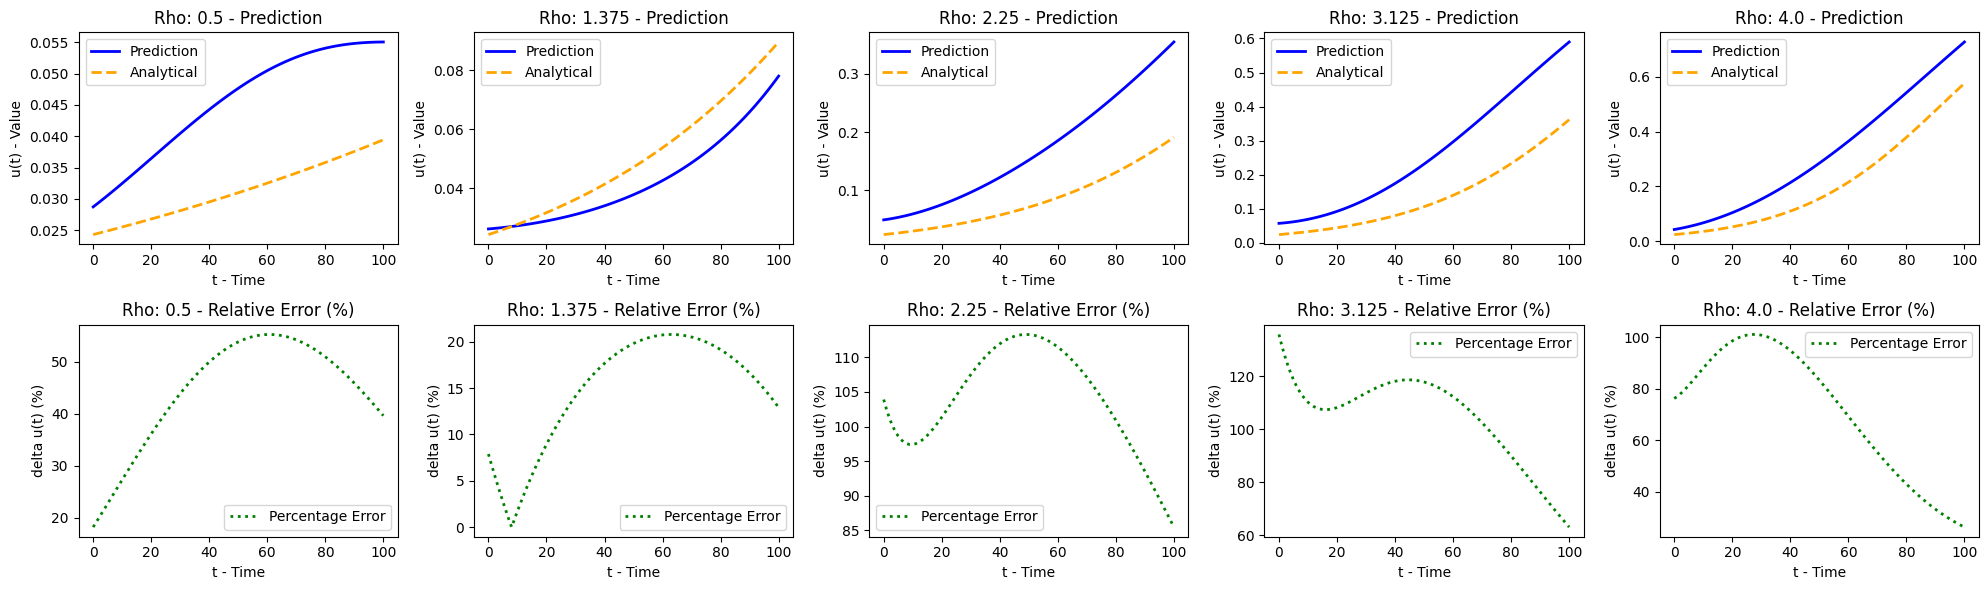

In [19]:
best_model1.eval()
predictions, analytical_solutions, errors = test_on_parameter_range(rho_values, dataset, best_model1)

# Plot predictions and errors
plot_predictions_and_errors(
    rho_values=rho_values,
    predictions=predictions,
    analytical_solutions=analytical_solutions,
    errors=errors,
    num_cols=len(rho_values),
    save_path=images_dir / "predictions_and_errors_pinnsformer_v1.png"
)

##### Tuning step 2
The previous results show, that higher `hidden_dim` values
are in fact not helpful. But increasing `head_num` is useful.


We explore the impact of the following params on convergence and performance:
1. adaptive_loss - on/off
2. only small hidden sizes (64,128)
3. different head counts
4. increasing number of iteration steps

Other params remain unchanged:
- `embedding_dim` - **fixed value**!
- `num_layers` - **fixed value**!

**Also:** Here we use a parameter regime (0.5-4.0) that is **representative** of all 3 regimes to train the model (Hence `repr` script). See `1d_logistic_ode_regimes.ipynb` for further information.

In [20]:
# Define rho values
start = 0.5
end = 4.0
rho_values = generate_rho_values(start, end, num=5)

# Create the dataset
dataset = ODEData(t_range=[0, 1], rho_values=rho_values, t_points=101, constant_x=1.0, device='cuda:0', use_time_sequencing=True)

# Define variations
normalize_res_values = [False]  # [True, False]
normalize_ic_values = [False]  # [True, False]
adaptive_loss = [(False,None)] #[(True,0.9), (False,None)]
#adaptive_loss_weighting_coeffs = [0.9]#[0.7, 0.9]
alpha_values = [None]  # [0.1, 0.25]
epsilon_values = [None]  # [0.1, 0.3]
iteration_steps = [120] #[200, 300, 500]  # [50, 100, 400]

# Define model variations
models = []
"""
model_variations = [
    (32, 1, 64, 1),
    (32, 2, 64, 1),
    (32, 2, 128, 1),
    (32, 1, 128, 1),
]
"""
model_variations = [
    (32, 2, 128, 1),
    (32, 4, 128, 1),
    (32, 2, 256, 1),
    (32, 4, 256, 1),
]
for emb_dim, num_heads, hidden_dim, num_layer in model_variations:
    model = PINNsformer(
        d_out=config.out_dim,
        d_model=emb_dim,
        d_hidden=hidden_dim,
        N=num_layer,
        heads=num_heads
    ).to(device)
    model.apply(init_weights)
    models.append((model, emb_dim, num_heads, hidden_dim, num_layer))

# Perform grid search
best_model2, best_config2, best_l12, best_l22 = perform_grid_search(
    config=config,
    dataset=dataset,
    rho_values=rho_values,
    device='cuda:0',
    models=models,
    normalize_res_values=normalize_res_values,
    normalize_ic_values=normalize_ic_values,
    adaptive_loss=adaptive_loss,
    alpha_values=alpha_values,
    epsilon_values=epsilon_values,
    iteration_steps=iteration_steps
)

# Print the results
print("Best Model Configuration:")
print(best_config2)
print(f"Best Average L1 Error: {best_l12}")
print(f"Best Average L2 Error: {best_l22}")
# Save the best model
model_path = weights_dir / "1d_logistic_ode_low_regime_pinnsformer_v2.pt"  # Path to save the model
torch.save(best_model2.state_dict(), model_path)
print(f"Model saved to {model_path}")

100%|██████████| 120/120 [00:27<00:00,  4.34it/s]


100%|██████████| 120/120 [00:26<00:00,  4.45it/s]


100%|██████████| 120/120 [00:26<00:00,  4.52it/s]


100%|██████████| 120/120 [00:26<00:00,  4.53it/s]


Best Model Configuration:
HyperparamConfig(total_i=120, dataset='1d-logistic-ode', model_name='pinnsformer', in_dim=3, hidden_dim=256, out_dim=1, num_layer=1, init_weights='xavier uniform', bias_fill=0.01, init_activ_func=None, subseq_activ_func=None, emb_dim=32, num_heads=2, optimizer='adam', learning_rate=0.001, batch_size=128, max_iter=None, line_search_fn=None, normalize_res=False, normalize_ic=False, alpha=None, epsilon=None, adaptive_loss_weighting=False, adaptive_loss_coeff=None)
Best Average L1 Error: 0.1450267732143402
Best Average L2 Error: 0.14215025305747986
Model saved to repr_regime/weights/1d_logistic_ode_low_regime_pinnsformer_v2.pt


Figure saved to repr_regime/images/predictions_and_errors_pinnsformer_v2.png


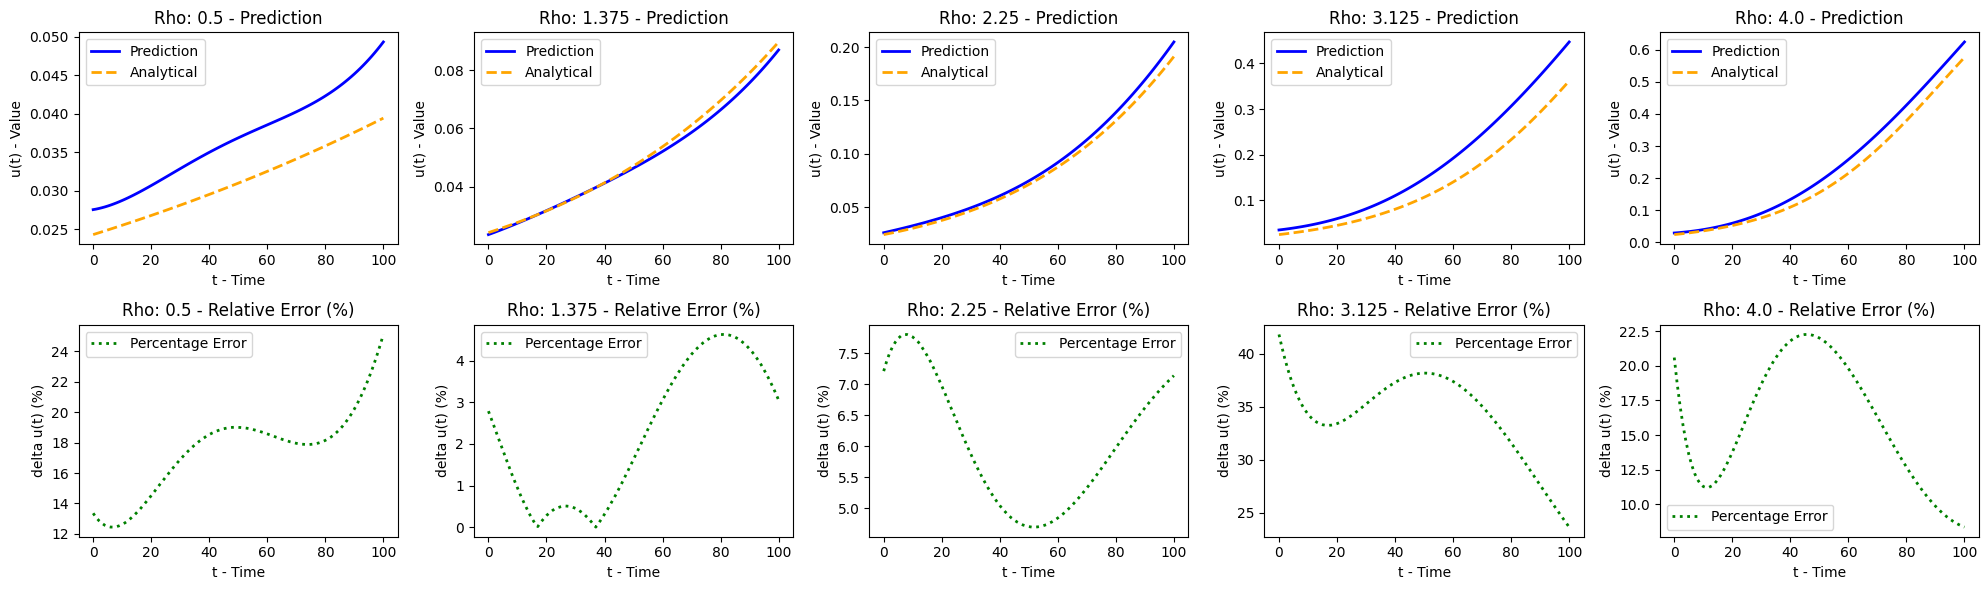

In [21]:
best_model2.eval()
predictions, analytical_solutions, errors = test_on_parameter_range(rho_values, dataset, best_model2)

# Plot predictions and errors
plot_predictions_and_errors(
    rho_values=rho_values,
    predictions=predictions,
    analytical_solutions=analytical_solutions,
    errors=errors,
    num_cols=len(rho_values),
    save_path=images_dir / "predictions_and_errors_pinnsformer_v2.png"
)

##### Tuning step 3
The previous results show, that higher `hidden_dim` values
are in fact not helpful. But increasing `head_num` is useful.


We explore the impact of the following params on convergence and performance:
1. adaptive_loss - on/off
2. only small hidden sizes (64,128)
3. different head counts
4. increasing number of iteration steps

Other params remain unchanged:
- `embedding_dim` - **fixed value**!
- `num_layers` - **fixed value**!

**Also:** Here we use a parameter regime (0.5-4.0) that is **representative** of all 3 regimes to train the model (Hence `repr` script). See `1d_logistic_ode_regimes.ipynb` for further information.

In [22]:
# Define rho values
start = 0.5
end = 4.0
rho_values = generate_rho_values(start, end, num=5)

# Create the dataset
dataset = ODEData(t_range=[0, 1], rho_values=rho_values, t_points=101, constant_x=1.0, device='cuda:0', use_time_sequencing=True)

# Define variations
normalize_res_values = [False]  # [True, False]
normalize_ic_values = [False]  # [True, False]
adaptive_loss = [(False,None)] #[(True,0.9), (False,None)]
#adaptive_loss_weighting_coeffs = [0.9]#[0.7, 0.9]
alpha_values = [None]  # [0.1, 0.25]
epsilon_values = [None]  # [0.1, 0.3]
iteration_steps = [250] #[200, 300, 500]  # [50, 100, 400]

# Define model variations
models = []
"""
model_variations = [
    (32, 1, 64, 1),
    (32, 2, 64, 1),
    (32, 2, 128, 1),
    (32, 1, 128, 1),
]
"""
model_variations = [
    (32, 2, 256, 1),
    (32, 4, 256, 1),
]
for emb_dim, num_heads, hidden_dim, num_layer in model_variations:
    model = PINNsformer(
        d_out=config.out_dim,
        d_model=emb_dim,
        d_hidden=hidden_dim,
        N=num_layer,
        heads=num_heads
    ).to(device)
    model.apply(init_weights)
    models.append((model, emb_dim, num_heads, hidden_dim, num_layer))

# Perform grid search
best_model3, best_config3, best_l13, best_l23 = perform_grid_search(
    config=config,
    dataset=dataset,
    rho_values=rho_values,
    device='cuda:0',
    models=models,
    normalize_res_values=normalize_res_values,
    normalize_ic_values=normalize_ic_values,
    adaptive_loss=adaptive_loss,
    alpha_values=alpha_values,
    epsilon_values=epsilon_values,
    iteration_steps=iteration_steps
)

# Print the results
print("Best Model Configuration:")
print(best_config3)
print(f"Best Average L1 Error: {best_l13}")
print(f"Best Average L2 Error: {best_l23}")
# Save the best model
model_path = weights_dir / "1d_logistic_ode_low_regime_pinnsformer_v3.pt"  # Path to save the model
torch.save(best_model3.state_dict(), model_path)
print(f"Model saved to {model_path}")

100%|██████████| 250/250 [00:58<00:00,  4.29it/s]


100%|██████████| 250/250 [00:55<00:00,  4.51it/s]


Best Model Configuration:
HyperparamConfig(total_i=250, dataset='1d-logistic-ode', model_name='pinnsformer', in_dim=3, hidden_dim=256, out_dim=1, num_layer=1, init_weights='xavier uniform', bias_fill=0.01, init_activ_func=None, subseq_activ_func=None, emb_dim=32, num_heads=4, optimizer='adam', learning_rate=0.001, batch_size=128, max_iter=None, line_search_fn=None, normalize_res=False, normalize_ic=False, alpha=None, epsilon=None, adaptive_loss_weighting=False, adaptive_loss_coeff=None)
Best Average L1 Error: 0.7556374669075012
Best Average L2 Error: 0.7795022130012512
Model saved to repr_regime/weights/1d_logistic_ode_low_regime_pinnsformer_v3.pt


Figure saved to repr_regime/images/predictions_and_errors_pinnsformer_v3.png


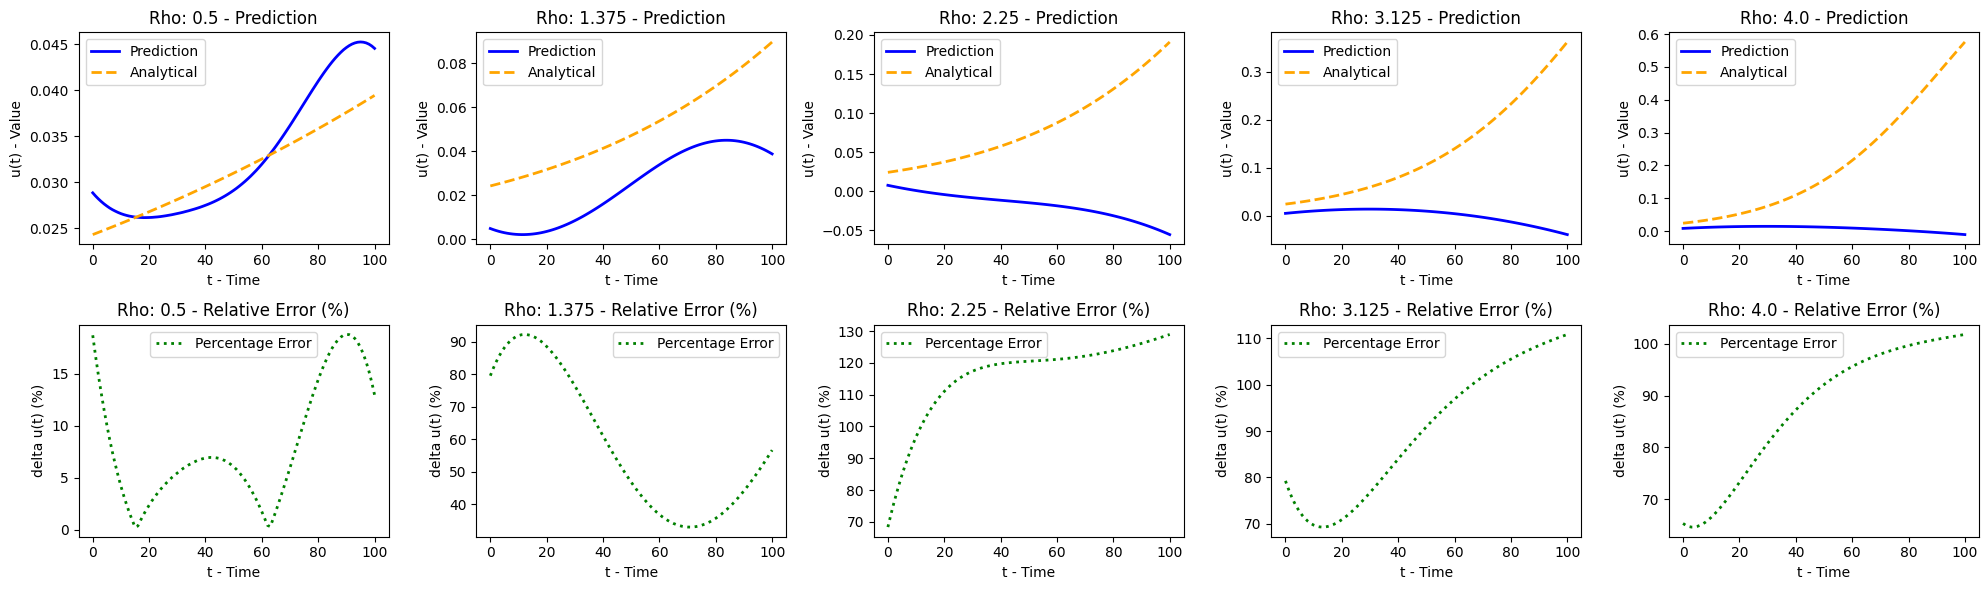

In [23]:
best_model3.eval()
predictions, analytical_solutions, errors = test_on_parameter_range(rho_values, dataset, best_model3)

# Plot predictions and errors
plot_predictions_and_errors(
    rho_values=rho_values,
    predictions=predictions,
    analytical_solutions=analytical_solutions,
    errors=errors,
    num_cols=len(rho_values),
    save_path=images_dir / "predictions_and_errors_pinnsformer_v3.png"
)

### Testing interpolation and extrapolation capabilities of models


In [24]:
## add additional import for visualization
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import pandas as pd

**Best model configuration:**

{'total_i': 400, 'dataset': '1d-logistic-ode', 'model_name': 'pinn_ff', 'in_dim': 3, 'hidden_dim': 256, 'out_dim': 1, 'num_layer': 4, 'init_weights': 'xavier uniform', 'bias_fill': 0.01, 'init_activ_func': 'tanh', 'subseq_activ_func': 'gelu', 'optimizer': 'adam', 'learning_rate': 0.001, 'batch_size': 128, 'normalize_res': False, 'normalize_ic': False, 'adaptive_loss_weighting': True, 'adaptive_loss_coeff': 0.9}


In [25]:
best_model = best_model2
best_config = best_config2

In [26]:
load_existing_model = False

if load_existing_model == True:
    best_model = PINNsformer(
                    d_out=best_config.out_dim,
                    d_model=best_config.emb_dim,
                    d_hidden=best_config.hidden_dim,
                    N=best_config.num_layer,
                    heads=best_config.num_heads).to(device)

    model_path = weights_dir / "1d_logistic_ode_fls_extended.pt"  # Path to the saved model
    best_model.load_state_dict(torch.load(model_path, map_location=device))
    best_model.eval()  # Set the model to evaluation mode

    print("Model loaded successfully!")

In [27]:
# Function 1: Generate uniformly spaced ρ values in a given range
def generate_rho_values(start, end, num=10):
    return np.linspace(start, end, num).tolist()

# Function 2: Evaluate model on ρ values and return error stats
def evaluate_rho_range(rho_values, dataset, model, device='cpu'):
    """
    Evaluate model performance across a range of rho values, using time-sequenced data.
    """
    results = []
    model.eval()  # Ensure model is in evaluation mode

    for rho in rho_values:
        # Generate test points with time sequencing enabled
        x_test, t_test, _ = dataset.get_interior_input_without_points()

        # Create appropriate rho tensor that matches the time-sequenced shape
        # For time-sequenced data, shape will be (batch_size, time_steps, 1)
        rho_test = torch.full((x_test.shape[0], x_test.shape[1], 1), rho).to(device)

        # Make predictions with time-sequenced data
        with torch.no_grad():
            pred = model(x_test.to(device), t_test.to(device), rho_test)

            # Ensure the prediction has the expected shape with time steps
            # It should be (batch_size, time_steps, 1) or similar
            if pred.dim() < 3:
                # If model doesn't preserve time dimension, reshape
                pred = pred.unsqueeze(1).expand(-1, x_test.shape[1], -1)

            # Flatten the prediction for error calculation
            # This combines all time steps into a single array
            pred_flattened = pred.cpu().detach().numpy().reshape(-1)

        # Compute analytical solution for each time step
        with torch.no_grad():
            u_analytical = dataset.analytical_solution(
                x_test, t_test, rho
            ).cpu().detach().numpy()

            # Flatten the analytical solution to match prediction
            u_analytical_flattened = u_analytical.reshape(-1)

        # for debugging
        # print(f"Prediction shape: {pred_flattened.shape}, Analytical shape: {u_analytical_flattened.shape}")

        # Calculate relative errors using flattened arrays
        rl1 = np.sum(np.abs(u_analytical_flattened - pred_flattened)) / np.sum(np.abs(u_analytical_flattened))
        rl2 = np.sqrt(np.sum((u_analytical_flattened - pred_flattened) ** 2) / np.sum(u_analytical_flattened ** 2))

        results.append({'rho': rho, 'rl1': rl1, 'rl2': rl2})

    return pd.DataFrame(results)

# Function 3: Plot scatter and compute Pearson correlation
def visualize_error_vs_rho(df, range_label=""):
    sns.set_theme(style='whitegrid')
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    axs[0].scatter(df['rho'], df['rl1'], color='blue', label='L1 Error')
    axs[0].set_title(f'L1 Error vs ρ ({range_label})')
    axs[0].set_xlabel('ρ')
    axs[0].set_ylabel('Relative L1 Error')

    axs[1].scatter(df['rho'], df['rl2'], color='green', label='L2 Error')
    axs[1].set_title(f'L2 Error vs ρ ({range_label})')
    axs[1].set_xlabel('ρ')
    axs[1].set_ylabel('Relative L2 Error')

    plt.tight_layout()
    plt.show()

    # Pearson correlations
    p_l1, _ = pearsonr(df['rho'], df['rl1'])
    p_l2, _ = pearsonr(df['rho'], df['rl2'])

    print(f"Pearson correlation (ρ vs L1): {p_l1:.3f}")
    print(f"Pearson correlation (ρ vs L2): {p_l2:.3f}")


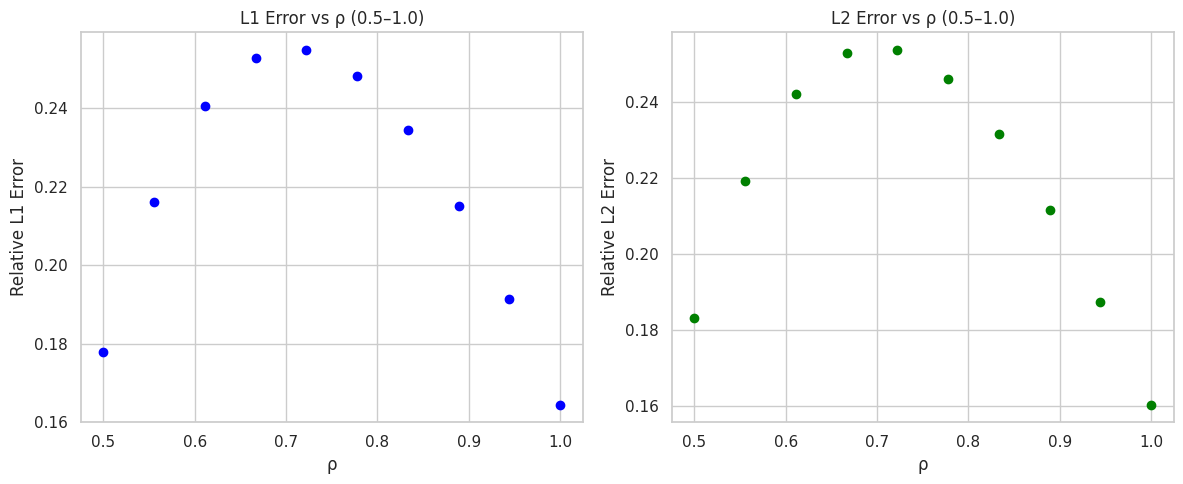

Pearson correlation (ρ vs L1): -0.274
Pearson correlation (ρ vs L2): -0.368


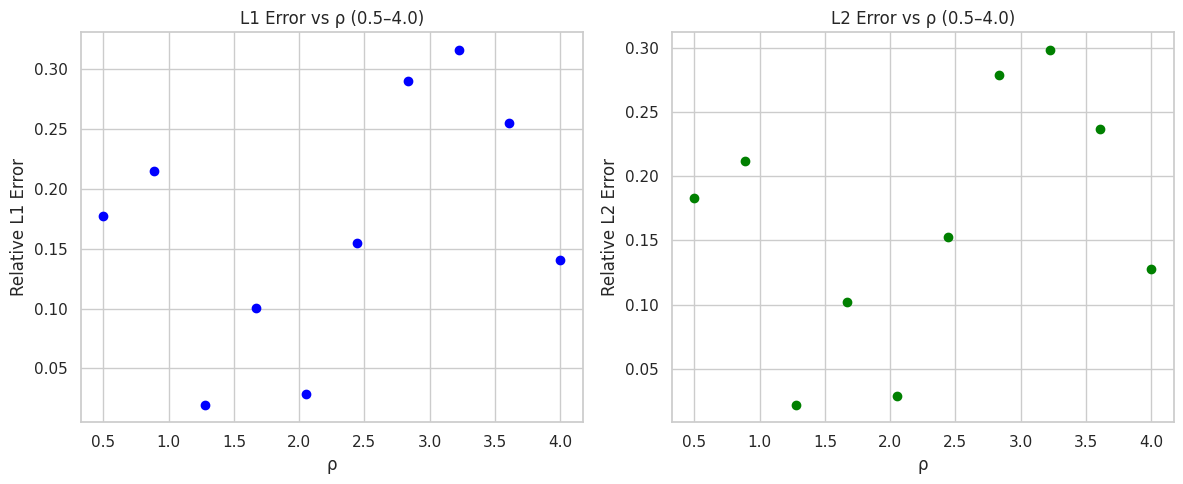

Pearson correlation (ρ vs L1): 0.382
Pearson correlation (ρ vs L2): 0.328


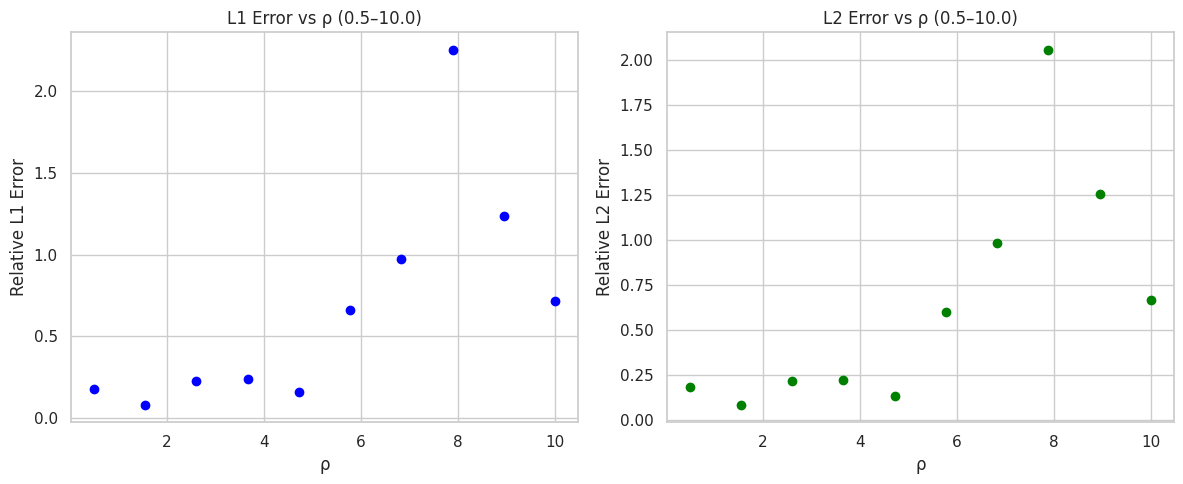

Pearson correlation (ρ vs L1): 0.697
Pearson correlation (ρ vs L2): 0.709


In [28]:
# Example usage loop over different rho ranges
ranges = [
    (0.5, 1.0),   # Low variance
    (0.5, 4.0),   # Medium variance
    (0.5, 10.0),  # High variance
]
dataset = ODEData(t_range=[0, 1], rho_values=[0.1, 0.3, 0.4], t_points=101, constant_x=1.0, device='cuda:0', use_time_sequencing=True) # here we can use dummy rho values

for start, end in ranges:
    rho_vals = generate_rho_values(start, end, num=10)
    df_results = evaluate_rho_range(rho_vals, dataset, best_model, device='cuda:0')
    visualize_error_vs_rho(df_results, range_label=f"{start}–{end}")

In [29]:
def compute_average_error_per_range(ranges, dataset, model, device='cuda:0', points_per_range=10):
    avg_errors = []

    for start, end in ranges:
        rho_values = np.linspace(start, end, points_per_range)
        df = evaluate_rho_range(rho_values, dataset, model, device=device)

        mean_l1 = df['rl1'].mean()
        mean_l2 = df['rl2'].mean()
        avg_errors.append({
            'range': f"{start:.1f}–{end:.1f}",
            'mean_l1': mean_l1,
            'mean_l2': mean_l2
        })

    return pd.DataFrame(avg_errors)


In [30]:
def plot_average_errors(df_avg):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Plot L1 Error
    sns.barplot(data=df_avg, x='range', y='mean_l1', ax=axs[0], hue='range', palette="Blues_d", dodge=False)
    axs[0].set_title('Average L1 Error per ρ Range')
    axs[0].set_ylabel('Mean L1 Error')
    axs[0].set_xlabel('ρ Range')
    legend = axs[0].get_legend()
    if legend:  # Check if the legend exists
        legend.remove()

    # Plot L2 Error
    sns.barplot(data=df_avg, x='range', y='mean_l2', ax=axs[1], hue='range', palette="Greens_d", dodge=False)
    axs[1].set_title('Average L2 Error per ρ Range')
    axs[1].set_ylabel('Mean L2 Error')
    axs[1].set_xlabel('ρ Range')
    legend = axs[1].get_legend()
    if legend:  # Check if the legend exists
        legend.remove()

    plt.tight_layout()
    plt.show()

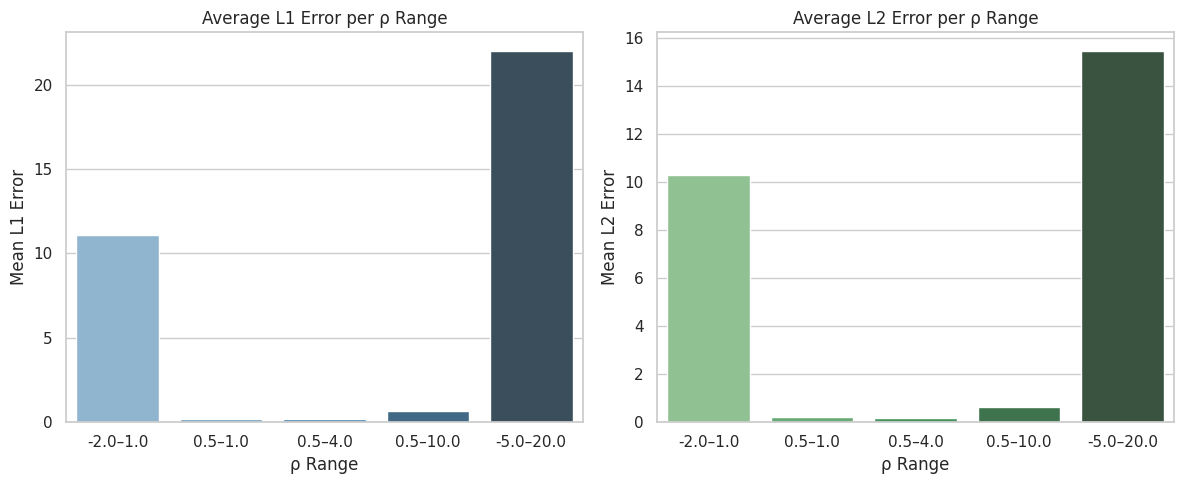

In [31]:
ranges = [
    (-2.0, 1.0),
    (0.5, 1.0),
    (0.5, 4.0),
    (0.5, 10.0),
    (-5.0, 20.0)
]

df_avg = compute_average_error_per_range(ranges, dataset, best_model, device='cuda:0')
plot_average_errors(df_avg)


### Analyzing convergence speed

In [32]:
# imports that might be missing
import pandas as pd
import copy

load_existing_model = True


In [33]:
if load_existing_model == True:
    best_model = PINNsformer(
                    d_out=best_config.out_dim,
                    d_model=best_config.emb_dim,
                    d_hidden=best_config.hidden_dim,
                    N=best_config.num_layer,
                    heads=best_config.num_heads).to(device)

    model_path = weights_dir / "1d_logistic_ode_low_regime_pinnsformer_v2.pt"  # Path to the saved model
    best_model.load_state_dict(torch.load(model_path, map_location=device))
    #best_model.eval()  # Set the model to evaluation mode

In [34]:
def run_fine_tuning_experiment(target_rho, best_model, iterations=50, device='cuda:0'):
    """
    Run a fine-tuning experiment comparing from-scratch training vs fine-tuning
    for a specific target rho value.

    Args:
        target_rho (float): The target rho value to fine-tune on
        best_model (nn.Module): The pre-trained model to fine-tune
        iterations (int): Number of training iterations
        device (str): Device to run training on

    Returns:
        dict: Contains baseline_metrics and finetune_metrics
    """

    from_scratch_model = copy.deepcopy(best_model)
    from_scratch_model.apply(init_weights)
    finetuned_model = copy.deepcopy(best_model)

    from_scratch_optimizer = torch.optim.Adam(from_scratch_model.parameters(), lr=1e-3)
    finetune_optimizer = torch.optim.Adam(finetuned_model.parameters(), lr=1e-3)


    dataset = ODEData(
        t_range=[0, 1],
        rho_values=[target_rho],
        t_points=101,
        constant_x=1.0,
        device=device,
        use_time_sequencing=True
    )

    # Configure training settings
    model_config_dict = {
        "total_i": iterations,
        "batch_size": 32,
        "normalize_res": False,
        "normalize_ic": False,
        "adaptive_loss_weighting": False,
        "adaptive_loss_coeff": 0.9,
        "alpha": 1.0,
        "epsilon": 1e-8
    }

    # Tracking structures for comparing convergence
    baseline_metrics = {'iterations': [], 'loss': [], 'rl1': [], 'rl2': []}
    finetune_metrics = {'iterations': [], 'loss': [], 'rl1': [], 'rl2': []}

    model_config_dict["mode"] = "from_scratch"
    print(f"Training baseline model from scratch for ρ={target_rho}...")
    baseline_loss_track, baseline_avg_l1, baseline_avg_l2 = run_training(
        model_config_dict,
        from_scratch_model,
        from_scratch_optimizer,
        dataset,
        [target_rho],
        device
    )

    model_config_dict["mode"] = "fine_tuned"
    print(f"Fine-tuning pre-trained model for ρ={target_rho}...")
    finetune_loss_track, finetune_avg_l1, finetune_avg_l2 = run_training(
        model_config_dict,
        finetuned_model,
        finetune_optimizer,
        dataset,
        [target_rho],
        device
    )

    # Extract metrics for plotting
    for i, metrics in baseline_loss_track.items():
        baseline_metrics['iterations'].append(i)
        baseline_metrics['loss'].append(metrics['avg_total_loss'])
        baseline_metrics['rl1'].append(metrics[f"{target_rho}_rl1"])
        baseline_metrics['rl2'].append(metrics[f"{target_rho}_rl2"])

    for i, metrics in finetune_loss_track.items():
        finetune_metrics['iterations'].append(i)
        finetune_metrics['loss'].append(metrics['avg_total_loss'])
        finetune_metrics['rl1'].append(metrics[f"{target_rho}_rl1"])
        finetune_metrics['rl2'].append(metrics[f"{target_rho}_rl2"])

    return {
        'target_rho': target_rho,
        'baseline_metrics': baseline_metrics,
        'finetune_metrics': finetune_metrics,
        'baseline_l1': baseline_avg_l1,
        'baseline_l2': baseline_avg_l2,
        'finetune_l1': finetune_avg_l1,
        'finetune_l2': finetune_avg_l2
    }

In [35]:
def plot_convergence_multi_rho(experiment_results, metrics=['rl2', 'loss']):
    """
    Plot convergence comparisons for multiple rho values.

    Args:
        experiment_results (list): List of dictionaries with experiment results
        metrics (list): List of metrics to plot (default: ['rl2', 'loss'])

    Returns:
        matplotlib.figure.Figure: The generated figure with subplots
    """
    num_rhos = len(experiment_results)
    num_metrics = len(metrics)

    fig, axes = plt.subplots(num_metrics, num_rhos, figsize=(5*num_rhos, 4*num_metrics))
    if num_metrics == 1 and num_rhos == 1:
        axes = np.array([[axes]])
    elif num_metrics == 1:
        axes = np.array([axes])
    elif num_rhos == 1:
        axes = np.array([[ax] for ax in axes])

    for metric_idx, metric in enumerate(metrics):
        for rho_idx, result in enumerate(experiment_results):
            ax = axes[metric_idx, rho_idx]
            target_rho = result['target_rho']
            baseline_metrics = result['baseline_metrics']
            finetune_metrics = result['finetune_metrics']
            ax.plot(
                baseline_metrics['iterations'],
                baseline_metrics[metric],
                'b-o',
                label=f'From Scratch'
            )
            ax.plot(
                finetune_metrics['iterations'],
                finetune_metrics[metric],
                'r-o',
                label=f'Fine-tuned'
            )

            ax.set_xlabel('Iterations')
            ax.set_ylabel(f'{metric.upper()}')
            ax.set_title(f'ρ={target_rho}')
            ax.grid(True, linestyle='--', alpha=0.7)
            ax.set_yscale('log')  # Log scale better shows convergence differences

            if rho_idx == 0:
                ax.legend()

    plt.tight_layout()
    return fig

def calculate_all_convergence_metrics(experiment_results, threshold=0.3):
    """
    Calculate convergence metrics for all experiments.

    Args:
        experiment_results (list): List of dictionaries with experiment results
        threshold (float): Error threshold for determining convergence

    Returns:
        pandas.DataFrame: DataFrame with convergence metrics
    """
    all_comparisons = []

    for result in experiment_results:
        target_rho = result['target_rho']
        baseline_metrics = result['baseline_metrics']
        finetune_metrics = result['finetune_metrics']

        # Find iterations where models first reach error threshold
        try:
            baseline_converged_at = next(i for i, v in enumerate(baseline_metrics['rl2'])
                                        if v < threshold)
        except StopIteration:
            baseline_converged_at = "Did not converge"

        try:
            finetune_converged_at = next(i for i, v in enumerate(finetune_metrics['rl2'])
                                        if v < threshold)
        except StopIteration:
            finetune_converged_at = "Did not converge"

        if isinstance(baseline_converged_at, int) and isinstance(finetune_converged_at, int):
            speedup = (baseline_converged_at / finetune_converged_at) if finetune_converged_at > 0 else float('inf')
            speedup_percentage = ((baseline_converged_at - finetune_converged_at) / baseline_converged_at) * 100
        else:
            speedup = "N/A"
            speedup_percentage = "N/A"

        all_comparisons.append({
            'Rho': target_rho,
            'Model': 'Baseline (From Scratch)',
            'Final RL1 Error': baseline_metrics['rl1'][-1],
            'Final RL2 Error': baseline_metrics['rl2'][-1],
            'Iterations to Converge': baseline_converged_at
        })

        all_comparisons.append({
            'Rho': target_rho,
            'Model': 'Fine-tuned',
            'Final RL1 Error': finetune_metrics['rl1'][-1],
            'Final RL2 Error': finetune_metrics['rl2'][-1],
            'Iterations to Converge': finetune_converged_at,
            'Speedup Factor': speedup,
            'Improvement %': speedup_percentage if isinstance(speedup_percentage, (int, float)) else speedup_percentage
        })

    return pd.DataFrame(all_comparisons)

In [36]:
def write_experiment_summary(experiment_results, output_file='fine_tuning_summary.txt', threshold=0.8):
    """
    Write a summary of fine-tuning experiment results to a text file.

    Args:
        experiment_results (list): List of dictionaries with experiment results
        output_file (str or Path): Path to the output summary file
        threshold (float): Error threshold for convergence determination
    """

    output_path = Path(output_file)
    output_path.parent.mkdir(parents=True, exist_ok=True)

    with open(output_path, 'w') as summary_file:
        summary_file.write("=== Summary of Findings ===\n\n")

        for result in experiment_results:
            target_rho = result['target_rho']
            baseline_l2 = result['baseline_metrics']['rl2'][-1]
            finetune_l2 = result['finetune_metrics']['rl2'][-1]

            # Calculate improvement percentage
            improvement = ((baseline_l2 - finetune_l2) / baseline_l2) * 100

            # Write to file
            summary_file.write(f"Rho = {target_rho}:\n")
            summary_file.write(f"  - From scratch final RL2: {baseline_l2:.6f}\n")
            summary_file.write(f"  - Fine-tuned final RL2: {finetune_l2:.6f}\n")
            summary_file.write(f"  - Error reduction: {improvement:.2f}%\n")

            # Try to identify if convergence threshold was reached
            try:
                baseline_converged_at = next(i for i, v in enumerate(result['baseline_metrics']['rl2']) if v < threshold)
                baseline_converged = True
            except StopIteration:
                baseline_converged = False

            try:
                finetune_converged_at = next(i for i, v in enumerate(result['finetune_metrics']['rl2']) if v < threshold)
                finetune_converged = True
            except StopIteration:
                finetune_converged = False

            if baseline_converged and finetune_converged:
                if finetune_converged_at == 0:
                    # Handle the case where fine-tuned model converged immediately
                    summary_file.write(f"  - Fine-tuned model already met threshold - immediate convergence!\n")
                    summary_file.write(f"  - Baseline model converged in {baseline_converged_at} iterations.\n")
                elif baseline_converged_at == 0:
                    # Handle case where baseline model converged immediately
                    summary_file.write(f"  - Both models converged immediately - they already met the threshold.\n")
                else:
                    # Normal case - both converged after some iterations
                    speedup = baseline_converged_at / finetune_converged_at
                    summary_file.write(f"  - Convergence speedup: {speedup:.2f}x (iterations: {finetune_converged_at} vs {baseline_converged_at})\n")
            elif finetune_converged and not baseline_converged:
                summary_file.write(f"  - Only fine-tuned model converged (in {finetune_converged_at} iterations)\n")
            elif baseline_converged and not finetune_converged:
                summary_file.write(f"  - Only baseline model converged (in {baseline_converged_at} iterations)\n")
            else:
                summary_file.write(f"  - Neither model converged to threshold {threshold}\n")

            summary_file.write("\n")

        # Add timestamp
        import datetime
        timestamp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        summary_file.write(f"\nSummary generated on: {timestamp}")

Training baseline model from scratch for ρ=0.5...


100%|██████████| 60/60 [00:08<00:00,  6.79it/s]


Fine-tuning pre-trained model for ρ=0.5...


100%|██████████| 60/60 [00:08<00:00,  6.79it/s]


Training baseline model from scratch for ρ=1.0...


100%|██████████| 60/60 [00:08<00:00,  6.95it/s]


Fine-tuning pre-trained model for ρ=1.0...


100%|██████████| 60/60 [00:08<00:00,  7.49it/s]


Training baseline model from scratch for ρ=3.0...


100%|██████████| 60/60 [00:08<00:00,  6.77it/s]


Fine-tuning pre-trained model for ρ=3.0...


100%|██████████| 60/60 [00:10<00:00,  5.96it/s]


Training baseline model from scratch for ρ=4.0...


100%|██████████| 60/60 [00:08<00:00,  6.82it/s]


Fine-tuning pre-trained model for ρ=4.0...


100%|██████████| 60/60 [00:08<00:00,  6.75it/s]


Training baseline model from scratch for ρ=5.0...


100%|██████████| 60/60 [00:08<00:00,  7.34it/s]


Fine-tuning pre-trained model for ρ=5.0...


100%|██████████| 60/60 [00:08<00:00,  7.49it/s]


Training baseline model from scratch for ρ=6.0...


100%|██████████| 60/60 [00:08<00:00,  6.74it/s]


Fine-tuning pre-trained model for ρ=6.0...


100%|██████████| 60/60 [00:08<00:00,  6.79it/s]


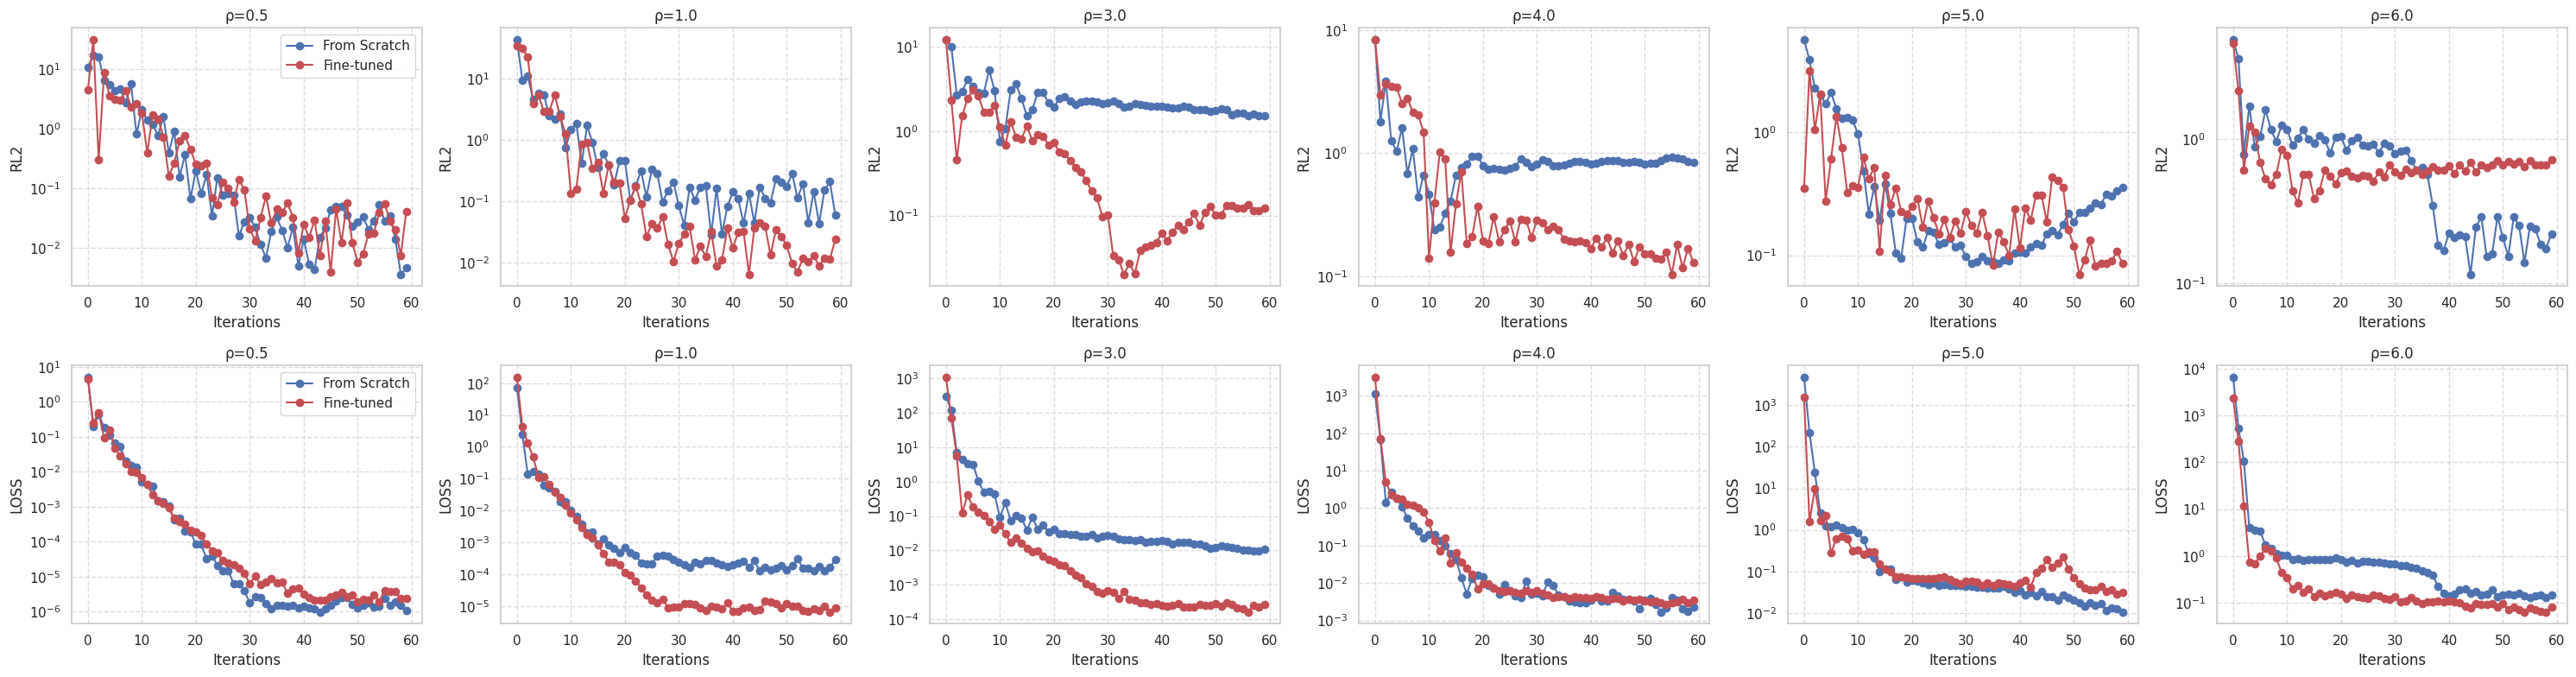

In [37]:
# Define target rho values for fine-tuning experiments
target_rho_values = [0.5, 1.0, 3.0, 4.0, 5.0, 6.0]
fine_tuning_iterations = 60
device = 'cuda:0'

base_dir = Path(".") / "repr_regime"
convergence_dir = base_dir / "convergence"
convergence_dir.mkdir(parents=True, exist_ok=True)

experiment_results = []
for target_rho in target_rho_values:
    result = run_fine_tuning_experiment(
        target_rho=target_rho,
        best_model=best_model,
        iterations=fine_tuning_iterations,
        device=device
    )
    experiment_results.append(result)

all_metrics_df = calculate_all_convergence_metrics(experiment_results)
all_metrics_df.to_csv(convergence_dir / 'multi_rho_convergence_metrics.csv', index=False)

fig = plot_convergence_multi_rho(experiment_results, metrics=['rl2', 'loss'])
fig.savefig(convergence_dir / 'multi_rho_convergence_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

write_experiment_summary(
    experiment_results,
    output_file=convergence_dir / 'fine_tuning_summary.txt',
    threshold=0.8
)